<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/Hull_and_Weighted_moving_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install ta
# !pip install pandas_datareader
# !pip install finta

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [ ]:
df = pdr.get_data_yahoo("COST","1/1/2018","1/1/2019")

In [ ]:
def Hanning(size):
    w = np.hanning(size+2)
    w = np.array(w[1:-1])  # remove zeros at endpoints
    return (w / max(w))

def wma(fs, size, pad=True, winType=Hanning, wts=None):
    """Apply a weighted moving average on the supplied series.
    Parameters
    ----------
    s : pandas.Series
        data to be averaged
    size : integer
        how wide a window to use
    pad : Boolean (optional, default = True)
        flag determining whether to pad beginning and end of data with a
        weighted average of the last `size` points. This provides better
        smoothing at the beginning and end of the line, but it tends to have
        zero slope.
    winType : Function (optional, default = Hanning)
        Window function that takes an integer (window size) and returns a list
        of weights to be applied to the data. The default is Hanning, a
        weighted cosine with non-zero endpoints. Other possible windows are:
        * np.bartlett (triangular with endpoints of 0)
        * np.blackman (3 cosines creating taper)
        * np.hamming (weighted cosine)
        * np.hanning (weighted cosine with endpoints of 0)
        * Triangle (triangle with non-zero enpoints, and option to
                    clip top of triangle)
    wts : list (optional, default = None)
        List of weights to use. `size` becomes the length of wts. Use this
        option to provide a custom weighting function. The length of wts
        should be odd, but this is not enforced.
    Returns
    -------
    Pandas Series containing smoothed data
    Notes
    -----
    Defaults to using a Hanning window for weights, centered on
    each point. For points near the beginning or end of data, special
    processing is required that isn't in built-in functions.
    Any rows with no value (nan) are dropped from series, and that reduced
    series is returned. This series will have fewer members than what was
    given, and may cause problems with mismatched indexes.
    """
    def SetLimits(i, hw):
        # i: current data location where window is centred
        # hw: half window width
        ds = max(0, (i-hw))         # data start
        de = min(n-1, (i+hw)) # data end
        ws = hw - (i - ds)          # window start
        we = hw + (de - i)          # window end
        return ds, de, ws, we

    s = fs.dropna()
    if type(wts) == type(None):
        size += (size+1) % 2  # make odd
        window = winType(size)
        window /= window.sum()  # normalize window
    else:
        window = wts / wts.sum()
        size = len(wts)
    n = len(s)
    hw = int(size / 2) # half window width
    # convolve has boundary effects when there is no overlap with the window
    # Begining and end of 'a' must be adjusted to compensate.
    # np.average() effectively scales the weights for the different sizes.
    if pad: # pad the data with reflected values
        # create padded beginning
        y = np.zeros(n+2*hw)
        for i in range(hw):
            y[i] = s.iloc[hw-i]
        for i in range(hw):
            y[i+n+hw] = s.iloc[n-i-1]
        for i in range(n):
            y[i+hw] = s.iloc[i]
        yc = np.convolve(y, window, mode='same')
        a = pd.Series(yc[hw:n+hw],
                      index=s.index,
                      name=s.name)
    else: # clip window as available data decreases
        a = pd.Series(np.convolve(s, window, mode='same'),
                      index=s.index,
                      name=s.name)
        for i in range(hw+1):  # fix the start
            (ds, de, ws, we) = SetLimits(i, hw)
            a.iloc[i] = np.average(s.iloc[ds:de], weights=window[ws:we])
        for i in range(n-hw-1, n):  # fix the end
            (ds, de, ws, we) = SetLimits(i, hw)
            a.iloc[i] = np.average(s.iloc[ds:de], weights=window[ws:we])
    return a

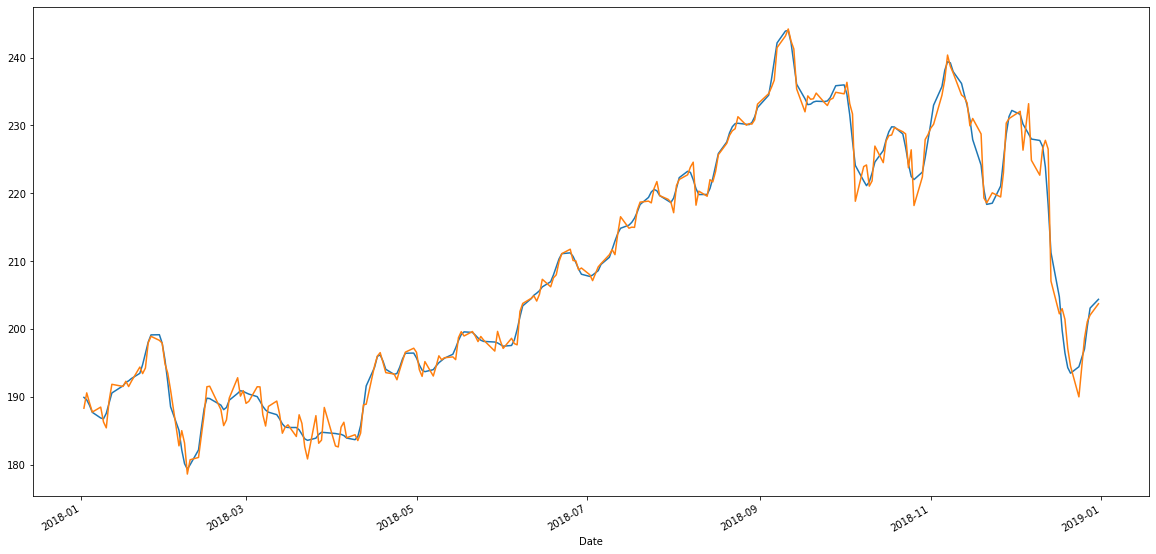

In [ ]:
def hma(df, n):
  a = 2 * wma(df, n/2)
  b = wma(df, n)
  return wma(a-b, np.sqrt(n))
# n = 25
# df['n/2'] = 2 * wma(df.Close,n/25)
# df['wma'] = wma(df.Close, n)
# df['hma'] = wma(df.wma, np.sqrt(n))
hma(df.Close,14).plot(figsize = (20,10))
df.Close.plot()

In [ ]:
df['hma1'] = hma(df.Close, 14)
df['hma2'] = hma(df.Close.shift(5),14)
df['D1'] = df.Close
df['D2'] = df.Close.shift(1)

In [ ]:
from finta import TA
help(TA.ICHIMOKU)

Help on method ICHIMOKU in module finta.finta:

ICHIMOKU(ohlc:pandas.core.frame.DataFrame, tenkan_period:int=9, kijun_period:int=26, senkou_period:int=52, chikou_period:int=26) -> pandas.core.frame.DataFrame method of builtins.type instance
    The Ichimoku Cloud, also known as Ichimoku Kinko Hyo, is a versatile indicator that defines support and resistance,
    identifies trend direction, gauges momentum and provides trading signals.
    
    Ichimoku Kinko Hyo translates into “one look equilibrium chart”.



In [ ]:
data = df[['Open','High','Low','Close']]
data.columns = ['open','high','low','close']
TA.ICHIMOKU(data)

,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,NaN,NaN,NaN,NaN,NaN
2018-01-04,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaN,NaN,NaN,NaN,NaN
2018-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-12-24,207.412222,219.713269,213.562745,224.504134,229.366923
2018-12-26,203.566110,218.340961,210.953536,223.948846,229.708846
2018-12-27,200.232223,217.138077,208.685150,223.456923,230.062692


In [ ]:
df['leadline1'] = TA.ICHIMOKU(data)['senkou_span_a']
df['leadline2'] = TA.ICHIMOKU(data)['SENKOU']

In [ ]:
df['MACD'] = hma(df.Close, 12) - hma(df.Close, 26)
df['aMACD'] = hma(df.MACD, 9)

In [ ]:
def strategy(df):
  for i in range(len(df)):
    if (df['hma1'][i] > df['hma2'][i]):# & (df['D1'] > df['D2']):# & (df.Close > df.hma2) & (df.leadline1 > df.leadline2) & (df.MACD > df.aMACD):
      return True
    else:
      return False

In [ ]:
signal = []
for i in range(len(df)):
  if (df.hma1[i] > df.hma2[i])  & (df.leadline1[i] > df.leadline2[i]) & (df.MACD[i] > df.aMACD[i]):# & (df['D1'][i] > df['D2'][i]) & (df.Close[i] > df.hma2[i]) & (df.leadline1[i] > df.leadline2[i]) & (df.MACD[i] > df.aMACD[i]):
    signal.append(1)
  else:
    signal.append(0)

In [ ]:
df['signal'] = signal

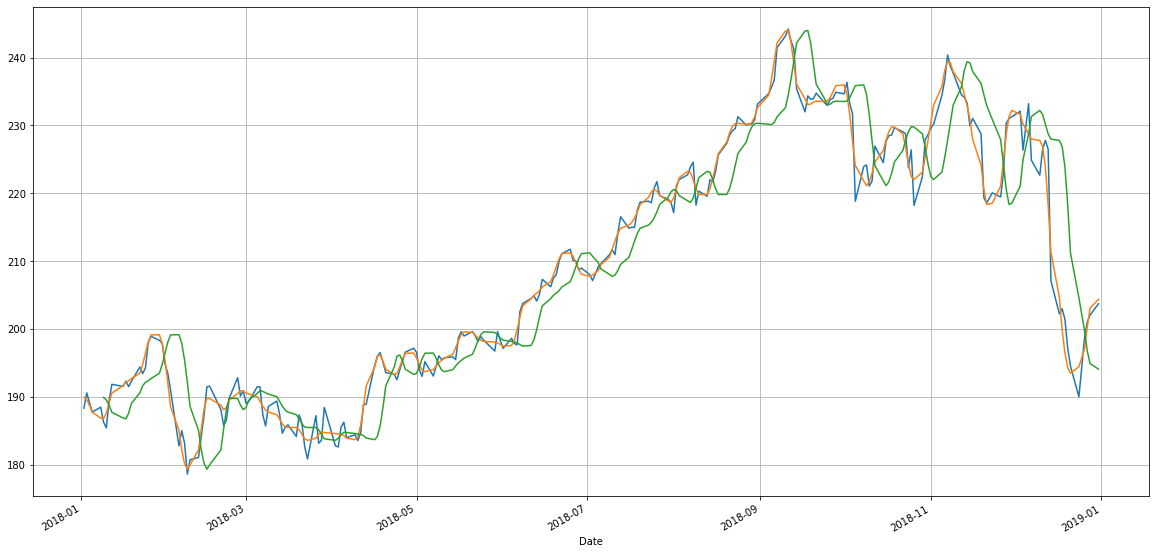

In [ ]:
df.Close.plot(figsize = (20,10))
# plt.scatter(df.index,df.Open, c = df.signal)
df.hma1.plot()
df.hma2.plot()
plt.grid()